# Locally Estimated Scatterplot Smoothing (LOESS)

Loess s a non-parametric regression method that combines multiple regression models in a k-nearest-neighbor-based meta-model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# yfinance is used to fetch data 
import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AMD'
start = '2014-01-01'
end = '2018-08-27'

# Read data 
dataset = yf.download(symbol,start,end)

# View Columns
dataset.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,3.85,3.98,3.84,3.95,3.95,20548400
2014-01-03,3.98,4.00,3.88,4.00,4.00,22887200
2014-01-06,4.01,4.18,3.99,4.13,4.13,42398300
2014-01-07,4.19,4.25,4.11,4.18,4.18,42932100
2014-01-08,4.23,4.26,4.14,4.18,4.18,30678700


In [3]:

import scipy.stats as stats
import statsmodels.api as sm

lowess = sm.nonparametric.lowess

In [4]:
x = dataset['Adj Close']
y = np.sin(x) + stats.cauchy.rvs(size=len(x))
z = lowess(y, x, frac= 1./3, it=0)
w = lowess(y, x, frac=1./3)

In [5]:
import scipy

In [6]:
# http://www.jtrive.com/loess-nonparametric-scatterplot-smoothing-in-python.html

def loc_eval(x, b):
    """
    Evaluate `x` using locally-weighted regression parameters.
    Degree of polynomial used in loess is inferred from b. `x`
    is assumed to be a scalar.
    """
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)



def loess(xvals, yvals, alpha, poly_degree=1):
    """
    Perform locally-weighted regression on xvals & yvals.
    Variables used inside `loess` function:

        n         => number of data points in xvals
        m         => nbr of LOESS evaluation points
        q         => number of data points used for each
                     locally-weighted regression
        v         => x-value locations for evaluating LOESS
        locsDF    => contains local regression details for each
                     location v
        evalDF    => contains actual LOESS output for each v
        X         => n-by-(poly_degree+1) design matrix
        W         => n-by-n diagonal weight matrix for each
                     local regression
        y         => yvals
        b         => local regression coefficient estimates.
                     b = `(X^T*W*X)^-1*X^T*W*y`. Note that `@`
                     replaces `np.dot` in recent numpy versions.
        local_est => response for local regression
    """
    # Sort dataset by xvals.
    all_data = sorted(zip(xvals, yvals), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)

    locsDF = pd.DataFrame(
                columns=[
                  'loc','x','weights','v','y','raw_dists',
                  'scale_factor','scaled_dists'
                  ])
    evalDF = pd.DataFrame(
                columns=[
                  'loc','est','b','v','g'
                  ])

    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = max(0,min(xvals)-(.5*avg_interval))
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)

    # Generate design matrix based on poly_degree.
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T


    for i in v:

        iterpos = i[0]
        iterval = i[1]

        # Determine q-nearest xvals to iterval.
        iterdists = sorted([(j, np.abs(j-iterval)) \
                           for j in xvals], key=lambda x: x[1])

        _, raw_dists = zip(*iterdists)

        # Scale local observations by qth-nearest raw_dist.
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 \
                      if j[1]<=1 else 0)) for j in scaled_dists]

        # Remove xvals from each tuple:
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))

        iterDF1 = pd.DataFrame({
                    'loc'         :iterpos,
                    'x'           :xvals,
                    'v'           :iterval,
                    'weights'     :weights,
                    'y'           :yvals,
                    'raw_dists'   :raw_dists,
                    'scale_fact'  :scale_fact,
                    'scaled_dists':scaled_dists
                    })

        locsDF    = pd.concat([locsDF, iterDF1])
        W         = np.diag(weights)
        y         = yvals
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'loc':[iterpos],
                       'b'  :[b],
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })

        evalDF = pd.concat([evalDF, iterDF2])

    # Reset indicies for returned DataFrames.
    locsDF.reset_index(inplace=True)
    locsDF.drop('index', axis=1, inplace=True)
    locsDF['est'] = 0; evalDF['est'] = 0
    locsDF = locsDF[['loc','est','v','x','y','raw_dists',
                     'scale_fact','scaled_dists','weights']]

    # Reset index for evalDF.
    evalDF.reset_index(inplace=True)
    evalDF.drop('index', axis=1, inplace=True)
    evalDF = evalDF[['loc','est', 'v', 'b', 'g']]

    return(locsDF, evalDF)

In [7]:
xvals = dataset['Open']
yvals = dataset['Adj Close']

In [8]:
regsDF, evalDF = loess(xvals, yvals, alpha=.6, poly_degree=1)

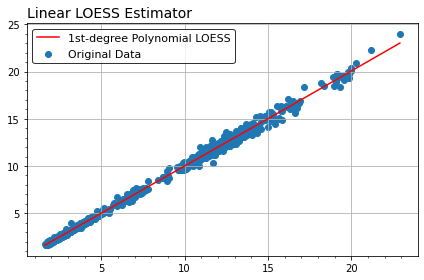

In [9]:
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values

# Generate x-y scatterplot with loess estimate overlaid.
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.minorticks_on()
ax1.scatter(xvals, yvals, label="Original Data")
ax1.plot(l_x, l_y, color='#FF0000', label="1st-degree Polynomial LOESS")
ax1.set_title("Linear LOESS Estimator", loc="left", fontsize=14)
ax1.legend(loc="upper left",
           scatterpoints=1,
           fontsize=11,
           frameon=True,
           fancybox=True,
           facecolor="#FFFFFF",
           edgecolor="#000000")
plt.tight_layout()
plt.show()